# Exploring test error on a simulated dataset

Note that this exercise has been modified to $p=15$, to be able to complete (c) in a reasonable time (BSS algorithm runtime is exponential in the number of predictors). The training error as a function of $p$ is nearly constant when $p = 15$ anyway.

## a. Generate the data

In [1]:
import numpy as np
import pandas as pd

# random X, coefficients, and noise
X = 1.1*np.random.rand(1000)
beta, e = np.random.rand(15, 1).flatten(), np.random.normal(size=1000)

# randomly zero 4 entries of beta
beta_zeros_indices = np.random.choice(15, 4)
beta = np.array([beta[i] if i not in beta_zeros_indices else 0 for i in range(len(beta))])

# data generated by degree 15 polynomial model
data = pd.DataFrame({'X^' + str(i): X**i for i in range(1, 16)})

# add response
data['y'] = np.matmul(data.values, beta) + e

data.head()

,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,X^11,X^12,X^13,X^14,X^15,y
0,0.571933,0.327107,0.187083,0.106999,0.061196,0.035000,0.020018,0.011449,6.547953e-03,3.744989e-03,2.141882e-03,1.225013e-03,7.006252e-04,4.007106e-04,2.291796e-04,1.508114
1,0.179980,0.032393,0.005830,0.001049,0.000189,0.000034,0.000006,0.000001,1.981650e-07,3.566581e-08,6.419147e-09,1.155321e-09,2.079351e-10,3.742424e-11,6.735629e-12,-0.155696
2,1.095461,1.200035,1.314592,1.440084,1.577557,1.728152,1.893123,2.073843,2.271815e+00,2.488685e+00,2.726257e+00,2.986509e+00,3.271605e+00,3.583916e+00,3.926041e+00,11.183512
3,0.644125,0.414897,0.267245,0.172139,0.110879,0.071420,0.046003,0.029632,1.908667e-02,1.229420e-02,7.918998e-03,5.100823e-03,3.285566e-03,2.116315e-03,1.363171e-03,0.783877
4,1.003829,1.007672,1.011530,1.015403,1.019291,1.023193,1.027111,1.031043,1.034991e+00,1.038954e+00,1.042932e+00,1.046925e+00,1.050933e+00,1.054957e+00,1.058996e+00,4.482393


## b. Train test split

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
%%capture

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['y']), 
                                                    data['y'], train_size=100)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 15), (900, 15), (100,), (900,))

## c. BSS on training data and train error

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# dict for mse results
bss_mses = {'num_pred': [], 'best_pred_idx': [], 'best_mse_train': []}

for k in range(1, 16):
    reg = LinearRegression()
    efs = EFS(reg, min_features=k, max_features=k, scoring='neg_mean_squared_error',
              print_progress=False, cv=None, n_jobs=-1)
    efs = efs.fit(X_train, y_train)
    bss_mses['num_pred'] += [k]
    bss_mses['best_pred_idx'] += [efs.best_idx_]
    bss_mses['best_mse_train'] += [-efs.best_score_]

In [6]:
bss_mses_df = pd.DataFrame(bss_mses)
bss_mses_df

,num_pred,best_pred_idx,best_mse_train
0,1,"(8,)",0.965216
1,2,"(7, 14)",0.960280
2,3,"(3, 4, 14)",0.955215
3,4,"(5, 6, 7, 8)",0.950193
4,5,"(2, 4, 5, 6, 7)",0.932734
5,6,"(0, 1, 2, 3, 4, 6)",0.868717
6,7,"(0, 2, 3, 4, 5, 6, 11)",0.856748
7,8,"(0, 2, 3, 4, 5, 6, 8, 14)",0.856729
8,9,"(0, 1, 5, 6, 7, 9, 10, 11, 12)",0.856044
9,10,"(0, 1, 6, 7, 9, 10, 11, 12, 13, 14)",0.855568


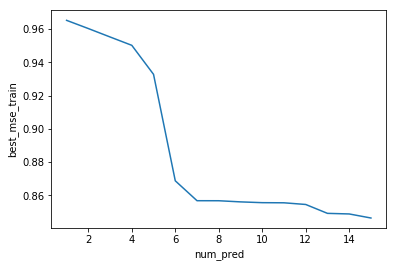

In [17]:
import seaborn as sns

sns.lineplot(x=bss_mses_df['num_pred'], y=bss_mses_df['best_mse_train'])

## d. BSS test error

In [8]:
# helper function which creates a full length beta with zero entries for ommitted predictors
def full_beta(beta_len, model_beta, pred_idx):
    beta, counter = np.zeros(beta_len), 0
    for i in pred_idx:
        beta[i] = model_beta[counter]
        counter += 1
    return beta

# helper which predicts test data >= features of train data
def diff_num_feat_pred(estimator, X_train, y_train, X_test, pred_idx):
    if len(pred_idx) == 1:
        model_beta = estimator().fit(X_train[:, pred_idx].reshape(-1, 1), y_train).coef_
    else:
        model_beta = estimator().fit(X_train[:, pred_idx], y_train).coef_
    beta_len = X_test.shape[1]
    beta = full_beta(beta_len, model_beta, pred_idx)
    return np.matmul(X_test, beta)


In [10]:
from sklearn.metrics import mean_squared_error

# track best model test error
bss_mses_df['best_mse_test'] = np.zeros(len(bss_mses_df))

for k in bss_mses_df.index:
    pred_idx = bss_mses_df.loc[k, 'best_pred_idx']
    y_pred = diff_num_feat_pred(LinearRegression, X_train.values, y_train, X_test, pred_idx)
    bss_mses_df.loc[k, 'best_mse_test'] = mean_squared_error(y_test, y_pred)

In [11]:
bss_mses_df

,num_pred,best_pred_idx,best_mse_train,best_mse_test
0,1,"(8,)",0.965216,1.330568
1,2,"(7, 14)",0.960280,1.269383
2,3,"(3, 4, 14)",0.955215,1.316338
3,4,"(5, 6, 7, 8)",0.950193,1.337739
4,5,"(2, 4, 5, 6, 7)",0.932734,1.159891
5,6,"(0, 1, 2, 3, 4, 6)",0.868717,7.432659
6,7,"(0, 2, 3, 4, 5, 6, 11)",0.856748,4.303755
7,8,"(0, 2, 3, 4, 5, 6, 8, 14)",0.856729,4.327183
8,9,"(0, 1, 5, 6, 7, 9, 10, 11, 12)",0.856044,4.543950
9,10,"(0, 1, 6, 7, 9, 10, 11, 12, 13, 14)",0.855568,4.293005


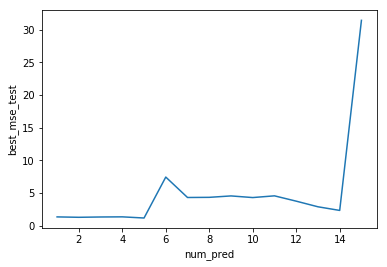

In [12]:
sns.lineplot(x=bss_mses_df['num_pred'], y=bss_mses_df['best_mse_test'])

## e. Model with minimum test error

Here is the best model by test mse:

In [16]:
bss_mses_df.loc[bss_mses_df['best_mse_test'].idxmin(), :]

num_pred                        5
best_pred_idx     (2, 4, 5, 6, 7)
best_mse_train           0.932734
best_mse_test             1.15989
Name: 4, dtype: object

And by train mse:

In [18]:
bss_mses_df.loc[bss_mses_df['best_mse_train'].idxmin(), :]

num_pred                                                         15
best_pred_idx     (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
best_mse_train                                             0.846343
best_mse_test                                               31.4469
Name: 14, dtype: object

The best model by test mse is not the best model by train mse

## f. Comparing best model and true model

The best model by test mse has only one third of the predictors of the full model. This is perhaps not surprising if we inspect the distributions of the features

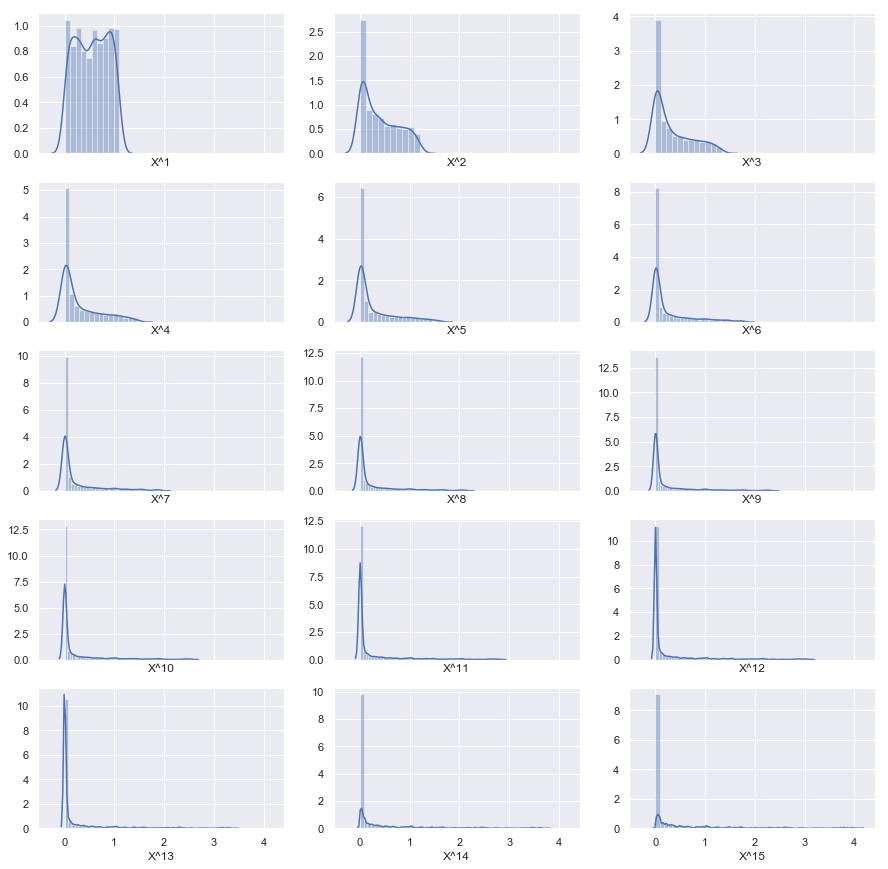

In [33]:
from itertools import product
import matplotlib.pyplot as plt

sns.set()
f, axes = plt.subplots(5, 3, figsize=(15, 15), sharex=True)
prod = list(product(range(5), range(3)))
for (i, j) in prod:
    sns.distplot(data.iloc[:, prod.index((i,j))], ax=axes[i, j])

The higher the power of $X$, the more concentrated the values are around 9